In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter

In [3]:
# Cargar el csv
csv_path = 'datos.csv'
df_courses = pd.read_csv(csv_path)

In [4]:
# Limpieza de datos del campo reviews
df_courses['Rating'] = pd.to_numeric(df_courses['Rating'], errors='coerce')
df_courses['Review'] = df_courses['Review'].str.replace(' reviews', '').replace(' review', '').str.replace(',', '').astype('float', errors='ignore')


In [5]:
# Carlcular el porcentaje de cada curso agrupado por el titulo
avg_rating_per_course = df_courses.groupby('Course Title')['Rating'].mean()

In [6]:
# Buscar los crusos con las altos y bajos ratings
highest_rated_course = df_courses.loc[df_courses['Rating'].idxmax()]
lowest_rated_course = df_courses.loc[df_courses['Rating'].idxmin()]

# Calcular el porcentaje de los cursos con horario flexible
flexible_courses = df_courses[df_courses['Schedule'] == 'Flexible schedule']
percent_flexible = round((len(flexible_courses) / len(df_courses)) * 100, 2)

# Resultado del análisis de cursos
print(f"Curso calificado mas alto: {highest_rated_course['Course Title']} con una calificación de {highest_rated_course['Rating']}")
print(f"Curso calificado mas baja: {lowest_rated_course['Course Title']} con una calificación de {lowest_rated_course['Rating']}")
print(f"Porcentaje de cursos flexibles: {percent_flexible}%")

Highest Rated Course: Songwriting: Writing the Music with a rating of 5.0
Lowest Rated Course: Excel for Beginners: Beginner Functions with a rating of 1.5
Percentage of Flexible Courses: 92.88%


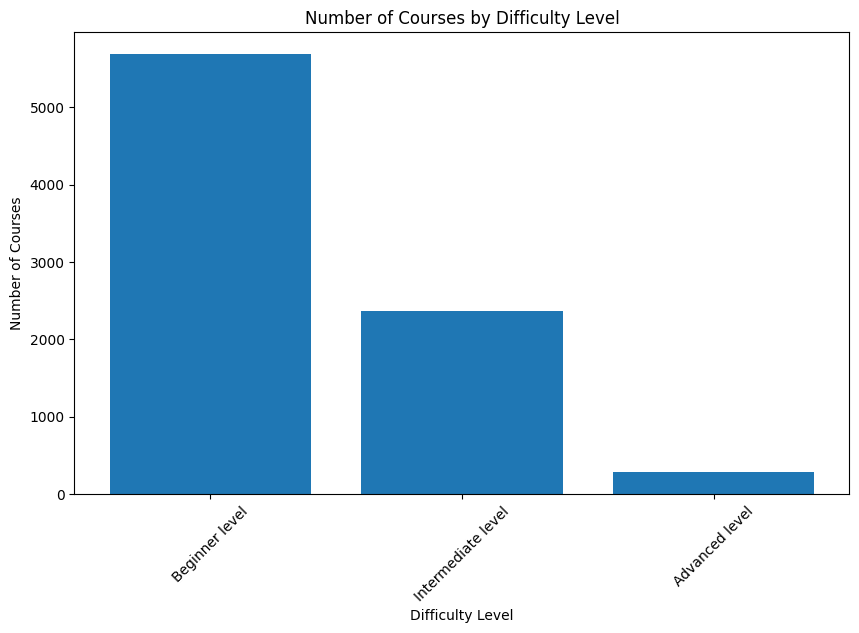

In [7]:
# Gráficas
# 1. gráfica de barras que muestre el número de cursos en cada nivel de dificultad.
difficulty_counts = df_courses['Level'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(difficulty_counts.index, difficulty_counts.values)
plt.title('Cantidad de cursos por nivel de dificultad')
plt.xlabel('Nivel de dificultad')
plt.ylabel('Cantidad de cursos')
plt.xticks(rotation=45)
plt.show()

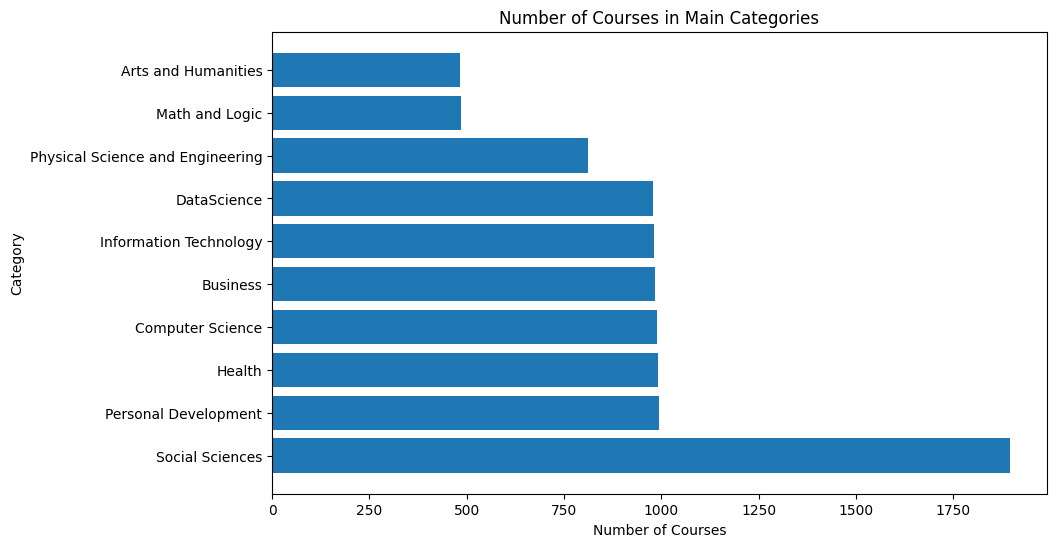

In [8]:
# 2. gráfica de barras horizontal que muestre el número de cursos en las principales categorías
category_counts = df_courses['Keyword'].value_counts().head(10)  # Top 10 categories
plt.figure(figsize=(10, 6))
plt.barh(category_counts.index, category_counts.values)
plt.title('Cantidad de cursos en categorías principales')
plt.xlabel('Cantidad de cursos')
plt.ylabel('Categorías')
plt.show()

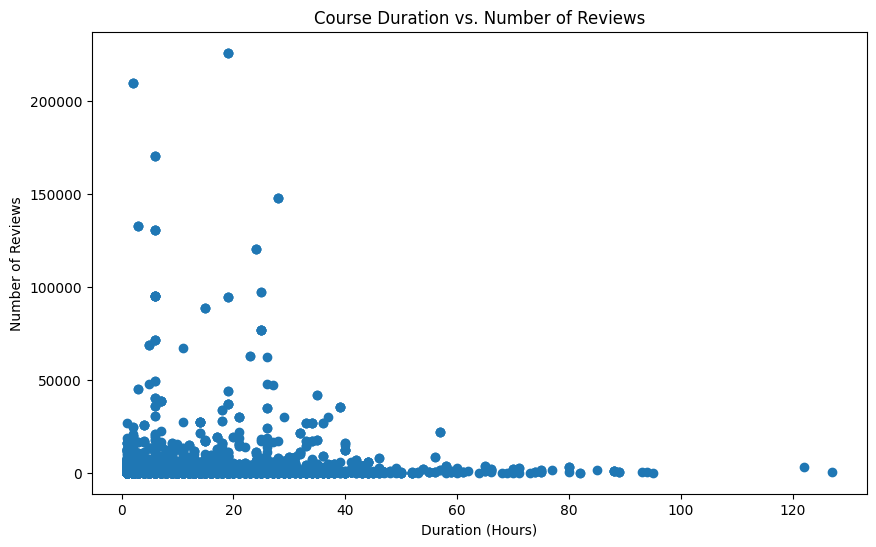

In [9]:
# 3. gráfico de dispersión para visualizar la relación entre la duración del curso y el número de revisiones
df_courses['Duration Hours'] = pd.to_numeric(df_courses['Duration'].str.extract('(\d+)')[0], errors='coerce')
plt.figure(figsize=(10, 6))
plt.scatter(df_courses['Duration Hours'], df_courses['Review'])
plt.title('Duración de Curso vs. Numero de Reviews')
plt.xlabel('Duración (Horas)')
plt.ylabel('Numero de Reviews')
plt.show()

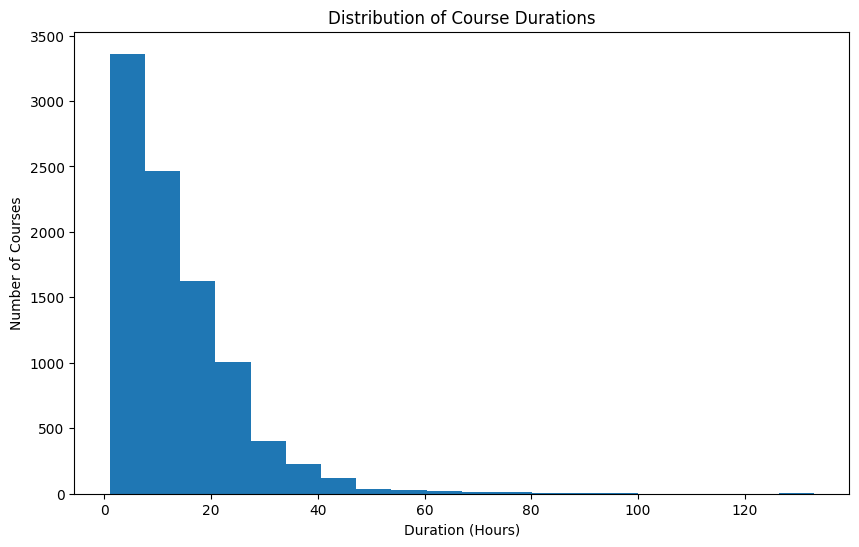

In [10]:
# 4. histograma de la distribución de las duraciones de los cursos
plt.figure(figsize=(10, 6))
plt.hist(df_courses['Duration Hours'].dropna(), bins=20)
plt.title('Distribución de duración de cursos')
plt.xlabel('Duración (Horas)')
plt.ylabel('Numeros de cursos')
plt.show()

<Figure size 1000x600 with 0 Axes>

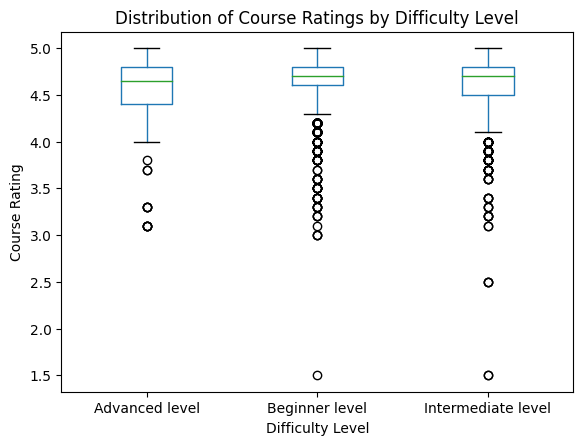

In [11]:
# 5. gráfico de cajas para visualizar la distribución de las calificaciones de los cursos por nivel de dificultad
plt.figure(figsize=(10, 6))
df_courses.boxplot(column='Rating', by='Level', grid=False)
plt.title('Distribución de las calificaciones de cursos por nivel de dificultad')
plt.xlabel('Nivel de Dificultad')
plt.ylabel('Calificaciones de cursos')
plt.suptitle('')
plt.show()

In [12]:
# Cargar el archivo de texto para analizar
txt_path = 'comments.txt'
with open(txt_path, 'r', encoding='utf-8') as file:
    text_data = file.read()

In [14]:
nltk.download('punkt')

# Tokenizacion
tokens = word_tokenize(text_data)

# Convetir a minusculas y remover signos de puntuación
tokens = [word.lower() for word in tokens if word.isalnum()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [15]:
# Eliminación de palabras vacias
nltk.download('stopwords')
stop_words = set(stopwords.words('spanish'))
filtered_tokens = [word for word in tokens if word not in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# Lematización y Stemming
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [17]:
# Frecuencia de palabras
word_freq = Counter(filtered_tokens)
print(f"Top 10 Palabras Más Frecuentes: {word_freq.most_common(10)}")

Top 10 Most Frequent Words: [('semana', 1641), ('curso', 1324), ('participantes', 837), ('ta', 836), ('dudas', 807), ('portafolio', 796), ('si', 641), ('1', 569), ('foros', 535), ('compañeros', 497)]


In [18]:
# Analisis de sentimientos
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
sentiment_scores = sia.polarity_scores(text_data)
print(f"Puntaje de Sentimientos: {sentiment_scores}")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment Scores: {'neg': 0.035, 'neu': 0.954, 'pos': 0.011, 'compound': -1.0}


In [19]:
# Reconocimiento de entidades nombradas
names = [word for word in tokens if word.istitle()]
print(f"Entidades extraidas: {names[:10]}")

Extracted Names: []
